In [7]:
from __future__ import print_function
from IPython.core.display import HTML
from fenics import *
import os
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
from dolfin import *
import numpy as np
import time
from math import *
import sympy as sym

from numpy.random import rand

from operator import mul
from functools import reduce

from scipy.integrate import odeint

from reaction_diffusion_symbolic_defs import *

from reaction_diffusion_source_functions import *

from replicateCOMSOL import *

%matplotlib inline
sym.init_printing()

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

The aim for this notebook is to extend the reaction-diffusion simulation to imitate the COMSOL outptut. 

# COMSOL model 

Rate equations:

$$\require{mhchem}$$  

<center>$\ce{H_2O <=>[k][kpK_{W}] H+ + OH-}$ 
<br> 
   <br> 
<center>$\ce{EPES + H <=>[k][kK_{aHEPES}] HEPES + H<=>[k][kK_{aHHEPES}] HHEPES}$ 
    

    

where [$H_2O$] is considered to be at a constant large concentration. 

Giving the dynamic ODEs:

$\frac{d[OH]}{dt}=k(pK_w - [H][OH])$
<br><br>
    $\frac{d[H]}{dt}=k(K_{aHEPES}[HEPES]-[EPES][H])+k(K_{aHHEPES}[HHEPES]-[HEPES][H])+k(pK_W-[H][OH])$
<br><br>
$\frac{d[EPES]}{dt}=k(K_{aHEPES}[HEPES] - [EPES][H])$
<br><br>
$\frac{d[HEPES]}{dt}=-k(K_{aHEPES}[HEPES]-[EPES][H]) +k(K_{aHHEPES}[HHEPES] - [HEPES][H])$
<br><br>
$\frac{d[HHEPES]}{dt}=-k(K_{aHHEPES}[HHEPES]-[HEPES][H])$

# Hadrien's speciation model for buffer capacity

Let $\beta \in \mathbb{R}_{\geq 0}$ denote the buffer capacity of a given $pH$ solution containing at least one monovalent Base-Acid pair $B^+-A^-$;
<br><br>
<center>$\beta = \frac{d[B^+]}{dpH} = -\frac{d[A^-]}{dpH}$
<br><br>
    
Let the set of cehmical species in the solution be denoted $S$ such that $ \tilde{S} = \{B^+,H^+,OH^-\} \subset S$ as each chemical in $\tilde{S}$ is monovalent the charge balance for the solution is;
   <br><br>
<center>$0= \sum_{i \in S/\tilde{S}}{[i]\bar{Z_i}} + [B^+] + [H^+] + (-1) [OH^-]$
<br><br>
    
Considering a small perturbation
$\delta[H^+]$in the $[H^+]$ concentration;
    
<br><br>
<center>$\frac{\partial[B^+]}{\partial[H^+]}= \lim_{\delta H^+\to0} \frac{[B^+]' - [B^+]_0}{\delta [H^+]} $
<br><br>
    
and
    
 <br><br>
<center>$\frac{\partial[B^+]}{\partial[H^+]}= \lim_{\delta H^+\to0} -\frac{[H^+]_0 +\delta [H^+] -[H^+]_0}{\delta [H^+]} + \frac{[HO^-]'-[HO^-]_0}{\delta [H^+]} - \sum_{i \in S/\tilde{S}} \frac{\bar{Z_i}' - \bar{Z_i}_0}{\delta [H^+]} $
<br><br>
    
gives;
 <br><br>
<center>$\frac{\partial[B^+]}{\partial[H^+]}= -1 + \frac{\partial[HO^-]}{\partial[H^+]} - \sum_{i \in S/\tilde{S}} \frac{\partial \bar{Z_i}}{\partial[H^+]} $
<br><br>

introducing the autoionisation of water;
<br><br>
<center>$pK_W = [H^+][OH^-]$
<br><br>
    
where $pK_W$ is a constant. Substituting into (?) provides;
 <br><br>
<center>$\frac{\partial [OH^-]}{\partial [H^+]} = \frac{-pK_W}{[H^+]^2}$
<br><br>  
    
so that;
 <br><br>
<center>$\frac{\partial[B^+]}{\partial[H^+]}= -1 - \frac{pK_W}{[H^+]^2} - \sum_{i \in S/\tilde{S}} \frac{\partial \bar{Z_i}}{\partial[H^+]} $
<br><br>
    
leaving the buffer capacity;
<br><br>
<center>$\beta = [H^+]log_{10}10 (1+\frac{pK_W}{[H^+]^2}+\sum_{i \in S/\tilde{S}} \frac{\partial \bar{Z_i}}{\partial[H^+]})$
<br><br>
    
Let $J_H$ denote the production flux of $H^+$ through reaction and therefore the rate of change of pH is given by;
 <br><br>
<center>$\frac{\partial pH}{\partial t} = \frac{-J_H}{\beta}$
<br><br>  

All that is left to determine is $\frac{\partial Z_i}{\partial[H^+]}$, which is found by considering the relation between the set of pseudoisomers (speciation states) for a master species. For master species, $i$, in the solution for a set of speciation states $C_i$ the average charge $z_i$ is given by;
 <br><br>
<center>$ \bar{Z_i}= \sum_{j \in C_i} z_{i,j} x_{i,j} $
<br><br>  
   
where $z_{i,j}$ is the charge of species $j$ in the speciation set of the $i$th master species. $x_{i,j}$ is the mole fraction of the specitation state $j$ in the master species $i$. Assume the ionic strength of the system is approximately temporally and spatially constant such that the dissociation equilibrium constant for each speciation state is constant and given by;
 <br><br>
<center>$ K_j = e^{\frac{\Delta_f G^0_{ref} + N^j_H \Delta_f G^0_{H^+} - \Delta_fG^0_j}{RT}}$
<br><br>  
    
where $R$ is the molar gas constant ad $T$ is the temperature of the solution. The Gibbs formation energies are for the reference state, $\Delta_f G^0_{ref}$, for the speciation state $j$, $\Delta_fG^0_j$, and for the formation of $[H^+]$, $\Delta_f G^0_{H^+}$.The reference species is taken to be the most deprotonated state in the set of speciation states $C_i$. Subsequently, the total molar amount of the master species, $n_i$ is given by;
    
<br><br>
<center>$ n_i = \sum_{j \in C_i} \frac{[H^+]^{N^j_H}}{K_j}$
<br><br>  
    
so;
 <br><br>
<center>$ \bar{Z_i}= \sum_{j \in C_i} z_{i,j} \frac{[H^+]^{N^j_H}}{K_jn_i}$
<br><br>  
    
as $\bar{Z_i} := \bar{Z_i}([H^+])$ it is differentiable with respect to $[H^+]$ and hence $\frac{\partial pH}{\partial t}$ may be determined. For a solution at zero ionic strength the dissociation equilibrium constant for the reference speceis is $K_{ref} = 1$. 
    

For the PH probe system the set of speciation states for the master, and reference, speceis $EPES$ is given by $C_{EPES} = \{EPES,HEPES,HHEPES\}$ and the parameters are:

| Species      | z_{i,j} |N^j_H | K_j|
| :----:       |    :----: | :----:| :----:|
| EPES         | -1 | 1| 1 |
| HEPES        |  0  | 1| K_aHEPES = 7|
| HHEPES       |1| 1| K_aHHEPES = 7 |  

Therefore the total molar amount of the master species is;
<br><br>
<center>$ n_{EPES} = \frac{9[H^+]}{7}$
<br><br>  
    
and the average charge;

<br><br>
<center>$ \bar{Z}_{EPES} = -\frac{7}{9}+0+\frac{7}{9} = 0$
<br><br>
    
therefore $\frac{\partial \bar{Z}_{EPES} }{\partial [H^+]} =0$ and;
    
 <br><br>
<center>$\frac{\partial pH}{\partial t} = \frac{-J_H}{[H^+]log_{10}10 (1+\frac{pK_W}{[H^+]^2})}$
<br><br>  

and as; 
    
<br><br>
<center>$ \frac{\partial [H^+]}{dt} = -[H^+] log_{10}10 \frac{\partial pH}{\partial t}$
<br><br> 
    
we get;
    
<br><br>
<center>$ \frac{\partial [H^+]}{dt}=  \frac{J_H }{1+\frac{pK_W}{[H^+]^2}}  $
<br><br>    
  

# Probe system geometry

The purpose of the simulations are to model the pH dynamics evolving from the addition of a probe into a liquid bulk system containig a cell. The bulk has a buffer capacity resisting the changes to the pH and the dynamics are modelled as a parabolic reaction-diffusion PDE system. Therefore without the hyperbolic affects of including fluid velocity it is assumed that the addition of chemical species from the probe does not displace fluid. The ouptu from COMSOL simualtions with realistic probe geometry is preseented in Figure 1. A simplification of the geometry into separate simulation domains is presented in Figure 2 before the system symmetry is exploited to further simplify the geometry into a 1-dimensional case, Figure 3.

![title](Tip_delivering_NaOH_showing_pH.png)

$\textbf{Figure 1:}$ 2-dimensional plot for the proton concentration, $H^+$, as output form the COMSOL model. The system has cylindrical symetry therefore the simulation is for radial model. The probe, in the subspace $[0,2] \times [2,11]$, contains a high concentration of $H^+$ acting a resevoir for the ssytem. A reaction-diffusion PDE was impelmented with the resulting diffusion of $H^+$ from the probe tip to the cell, subspace $[0,4] \times [0,1]$. The majority of the space may be seen to remain at the same concentration suggesting a superfluous space to model. 

The system geometry was simplified by considering a subspace of the original simulation. This was done to improve the simulation numerics by removing the domain space where the spatial variation is minimal. The subspace, shown in Figure 2 - a was then broken into subdomains shown in Figure 2 - b. 

| Subdomain      | Label |  Source term  | 
| :----:       |    :----:   | :----:| 
| $\Omega_0$   | Bulk  |  $R$ |
| $\Omega_1$   | Cell  |  $K_{Cell}$ |
| $\Omega_2$   | Probe  |  $K_{Bulk}$ |
| $\Omega_3$   | Waveguide  |  0 |
| $\Omega_4$   | Waveguide  |  0 |

| Subboundary      | Label |  Boundary Type  | Boundary function|
| :----:       |    :----:   | :----:|  :----:| 
| $\Gamma_0$   | Bulk-outer  |   |  |
| $\Gamma_1$   |  Cell-outer |   |  |
| $\Gamma_2$   | Probe-outer  |   |  |
| $\Gamma_3$   | Waveguide-bulk  |  Neumann | 0 |
| $\Gamma_4$   | Waveguide-bulk  |  Neumann | 0 |
| $\Gamma_5$   | Probe-bulk  |   |  |
| $\Gamma_6$   | Probe-cell  |   |  |

For N-dimensional domain $\Omega \subset \mathbb{R}^N$ for $\forall \vec{x} \in \Gamma \subset \partial \Omega$, for a given scalar function $f(\vec{x})$

Dirichlet:
<br><br>
<center>$ y(x) = f(x) $
<br><br>  
    
Neumann:
<br><br>
<center>$ \frac{\partial y}{\partial \vec{n}}(\vec{x}) = f(\vec{x}) $
<br><br>  
    
where $\vec{n}$ is the unit outer normal to the boundary surface.
    
Robin:
<br><br>
<center>$ \alpha u + \beta \frac{\partial u}{\partial \vec{n}} = f(\vec{x}) $
<br><br>  

a weighted combination of the Dirichlet and Neumann BCs for weight constants $\alpha,\beta$.

![title](simulationGeometrySchematic.png)

$\textbf{Figure 2:}$ Cartoon showing the relevant subspace of the COMSOL simultation, Figure 1, with a simplification diagram. a) The rectangle subspace of Figure 1 $[0,2] \times [0,3]$ was reflected along the y-axis for the symmetric probe. The subspace contains the tip of the probe, top-middle, and the edge of the cell, bottom of the figure. b) Cartoon schematic for the domain of the simulation. The figure a) was converted in to 5 distict bounded domains, $\Omega = \bigcup_{i=0}^5 \Omega_i$. The mapping assumes that the radius of curvature of the cell is large compared to the distance to the probe tip therefore the cell modelled as a locally planar surface. Likewise, the probe tip was assumed to be locally flat.

Beyond the reducion of geometric complexity further simplifications may be reasonable. Without the intoduction of hyperbolic fluid flow, reaction-diffuision dynamics for the highly symmetric system may be abel to remove the lateral component of the dynamics considering only the normal direction to the cell, as shown in Figure 3. This would reduce the probe to either an extended region or a point source. In this scenario the cell would be modeled as a second region or even by another point source.

![title](geometryTo1D.png)

$\textbf{Figure 3:}$ figure showing the reduction of the system geometry to a 1-dimensional case. The reflected probe-cell geometry, a), is symmetric along the y-axis (green dashed line). Threrefore the goemetry may be simplified along this axis. b) The simplified geomerty reduces the system to a 1-dimensional line segmented by the three different sub-domains; probe, bulk, and cell. Using this simplification and assuming the distance between the probe and cell is large the probae may be simplified further by considering a point source for both the probe and cell.  

# Heat from a point source [1]

Consider a source of heat of strength Q at a point, $\vec{r}'$ in the domain, figure 4 a). The heat distribution in the domain satisfies the heat diffusion pde; 

$$ \frac{\partial v}{\partial t} - \vec{D} \cdot \nabla^2v= 0$$

Consider the radial diffusion of heat from a sphere source of radius a. Convertng the heat diffusion into spherical coordinates;

$$ \frac{\partial v}{\partial t} = D\{\frac{1}{r^2}\frac{\partial}{\partial r}(r^2\frac{\partial v}{\partial r})+ \frac{1}{r^2sin\theta}\frac{\partial}{\partial\theta}(sin\theta\frac{\partial v}{\partial\theta})+\frac{1}{r^2sin^2\theta}\frac{\partial^2v}{\partial\theta^2}\}$$

considering the spherically symetric symmetric form;

$$ \frac{\partial v}{\partial t} = D(\frac{\partial^2 v}{\partial r^2}+\frac{2}{r}\frac{\partial \dot{v}}{\partial r}) $$

Using a radial change of variables $u = vr$;

$$ \frac{\partial u}{\partial t} = D(\frac{\partial^2 u}{\partial r^2}) $$

consider the sphere radius $a$ to have a heat density, $\rho$, located at the origin with zero heat elsewhere in the domain. The solution for the heat at a radial test point $r$ is;

$$ v = \frac{\rho}{2r(\pi D t)^{\frac{1}{2}}} \int_{0}^{a} r' e^{\frac{r'^2}{4Dt}}(e^{rr'/2Dt}  -e^{-rr'/2Dt})dr' = \frac{\rho}{2}({erf\frac{r+a}{2(Dt)^{\frac{1}{2}}} - erf\frac{r-a}{2(Dt)^{\frac{1}{2}}} -\frac{2(Dt)^{\frac{1}{2}}}{r\pi^{\frac{1}{2}}}}[e^{-\frac{(r-a)^2}{4Dt}}-e^{-\frac{(r+a)^2}{4Dt}}])$$

where $erf(z)$ denotes the "error function";

$$ erf(z) = \frac{2}{\sqrt{\pi}} \int_0^z e^{-x^2} dx \approx 1-\frac{e^{-z^2}}{\sqrt{\pi}}(1-\frac{1}{2z^2}+...) $$

denoting the total amount of heat liberated by the sphere as $Q = \frac{4}{3} \pi a^3 \rho$ and letting the radius of the sphere, $a$, tend to zero the point source heat distribution in 3D space becomes;

$$ v = \frac{Q}{8(\pi Dt)^\frac{3}{2}} e^{-(|\vec{r}-\vec{r}'|^2)/4dt} $$ 

due to the symmetry of the point source, the 2D form is given by;

$$ v = \frac{Q}{4\pi Dt} e^{-(|\vec{r}-\vec{r}'|^2)/4Dt} $$ 

Consider a point source of non-constant heat source. The heat liberated at a pont $\vec{r}'$ at a rate $\phi (t)$ per unti time. The temperature at a test point $\vec{r}$ at a time, $t$, is therefore the summation of the heat liberated from source over the time elapsed. For the 3D case, let $r^2 = \vec{r} \cdot \vec{r}' = (x-x')^2 + (y-y')^2 + (z-z')^2$, the temperature distribution is therefore;

$$ v(\vec{r},t) = \frac{1}{8(\pi D)^{3/2}}\int_0^t \phi(t') e^{-r^2/4D(t-t')} \frac{dt'}{(t-t')^{3/2}}$$

Consider a source of constant power, i.e $\phi (t) = q$, the temperature at a test point $\vec{r}$ is given by the distribution;

$$ v(\vec{r}, t) = \frac{q}{4(\pi D)^{3/2}} \int_{1/\sqrt{t}}^{\infty} e^{r^2\tau^2/4D} d\tau = \frac{q}{4\pi D r} erfc(\frac{r}{\sqrt{4Dt}})$$

where $\tau = (t-t')^{\frac{1}{2}}$ and $erfc(z)$ is the "complementary error function" defined;

$$ erfc(z) = 1-erf(z) = \frac{2}{\sqrt{\pi}}\int_z^\infty e^{-x^2}dx $$


As before, we can use symmetry to find the equivalent 2D case which is given by;

$$ v(\vec{r},t)  = \frac{1}{4\pi Dt}\int_0^t \phi(t') e^{-r^2/4D(t-t')} \frac{dt'}{(t-t')}$$ 

where we necessarily re-define $r^2 = \vec{r} \cdot \vec{r}' = (x-x')^2 + (y-y')^2$

with a solution;

$$ v(\vec{r},t) = \frac{q}{4\pi D} \int_{r^2/4Dt}^\infty \frac{e^{-u}}{u}du = -\frac{q}{4 \pi D} Ei(-\frac{r^2}{4Dt})$$

where $u=\frac{r^2}{4D(t-t')}$ and $Ei(z)$ denotes the "exponential integral";

$$ Ei(-x) = - \int_x^\infty \frac{e^{-u}}{u} du = \gamma + ln(x) - x +\frac{1}{4}x^2 + O(x^3)$$ where $\gamma \approx 0.5772...$ Euler's constant.

For a periodic point source of unit strength $\phi(t) = e^{i\omega t}$. In the 3D case; 

$$ v(\vec{r},t) = \frac{1}{8(\pi D)^{3/2}} \int_{-\infty}^t e^{\iota \omega t' - r^2/4D(t - t')} \frac{dt'}{(t-t')^{3/2}} = \frac{1}{4\pi D r} e^{-\vec{k}\cdot \vec{r} +\iota (\omega t -\vec{k}\cdot\vec{r})}$$
 
a decaying wave of frequency $\omega$ and where $\vec{k}=\sqrt{\frac{\omega}{2D}}$.

In the 2D case;

$$ v(\vec{r},t) = \frac{1}{4\pi D} \int_{-\infty}^{t}e^{\iota \omega t'-r^2/4D(t-t')}\frac{dt'}{t-t'} = \frac{1}{2\pi D} e^{\iota \omega t}K_0[(\frac{\iota \omega}{D})^{1/2}r]$$

where $K_0 = ....$












# Heat from multiple sources

Consider a sequence of sources, figure 4 b-d). In the limit of an infinite number of point sources with infinitesimal pairwise distance, the point sources will act as a line source [2]. Gillespie considered a cluster of points acting as ion channels in a reaction-diffusion system using propogation integrals to approximater an analytic result. To start with only diffusive and source dynamics were considered before introducing a reaction term under excess buffer assumptions [3].

Consider a point surce located at a position $\vec{r}$ representing a channel of time-dependent flux $j(t)$ and channel condition $\chi(t) \in {0,1}$ representing whether the channel is closed or open, respectively. The source is only active at point $\vec{r}$ and the source contribution is given by;

$$ s(t,\vec{r}) = \chi(t)j(t)\delta (\vec{r}) $$

producing the source term of theion diffusion system;

$$ \frac{\partial u}{\partial t} = D \nabla ^2 u(t,\vec{r}) + s(t,\vec{r}) $$

Restricting to 2 dimension (planar case) and discritising the time, $t_n$, for time step, $n$, prvides a solution form of;

$$ u(t_{n+1}, \vec{r}) = \chi_n j_n u_1(\Delta t,\vec{r}) + u_2(n,\vec{r})$$

where $u_1$ is the contribution at test point $\vec{r}$ due to the addition and propogation of ions at the source point and $u_2$ is the propogation of the result from the previous timestep. 

The different ion concentration components are given by propogation integrals for the discritised times over a spatial domain $\Omega$ with a source at point $\vec{r}'$ [4];

$$ u_1(n\Delta t),\vec{r}) = \int_0^{t_n} 4\pi D (t_n -t) \int_\Omega e^{-|\vec{r}-\vec{r}'|^2/4D(t_n-t)}\delta(\vec{r}')d\vec{r}'dt$$

and 

$$ u_2(k,\vec{r}) = \frac{1}{4 \pi D} \int_{\Omega} e^{-|\vec{r}-\vec{r}'|^2/4D(\Delta t)} u(t_n,\vec{r}')d\vec{r}'  $$

The contribution by a point source in 2D is;

$$ u_1(t,\vec{r}) = \frac{1}{4\pi D}  \Gamma(0,(|\vec{r}|/\sqrt{4Dt})^2)  $$

where $\Gamma$ is the "incomplete Gamma function";

$$ \Gamma(a,b) = \int_b^{\infty} t^{a-1} e^{-t}dt $$

and for a value $x > 0$ \satisfies the standard case

$$ \Gamma(0,x) = - Ei(-x)$$ 

After taking the Fourier transform of the discritised propogation integrals leads to a recurrence relation for the ion flux at a point $\vec{r}$. The material distribution at the $nth$ time step is computed through the summation of all previous timesteps staring from an initial distribution $u(0,\vec{r})0$ adding any background material concentration.  

$$ u(t_{n+1},\vec{r}) = \sum_{m=0}^n \chi_{n-m}j_{n-m}(u_1((m+1)\Delta t,\vec{r}) - u_1(m\Delta t,\vec{r})) $$

which provides the solution;

$$ u(t_{n+1},\vec{r}) = \sum_{m=0}^n \chi_{n-m}j_{n-m}(\frac{1}{4\pi D}  \Gamma(0,(|\vec{r}|/\sqrt{4D(m+1)\Delta t})^2) - \frac{1}{4\pi D}  \Gamma(0,(|\vec{r}|/\sqrt{4Dm\Delta t})^2) $$

taking the limit of $\Delta t \to 0$ and hence $n \to \infty$ allows the ion current source to smoothly vary providing;

$$ \lim_{\Delta t \to 0}u(t,\vec{r}) = \int_0^t \chi(t-t')j(t-t')\frac{\partial u_1}{\partial t}(t',\vec{r})dt'$$

which for the 2D case, using the Leibiz integral rule, reduces to;

$$ \lim_{\Delta t \to 0}u(t,\vec{r}) = \int_0^t \chi(t-t')j(t-t')\frac{1}{4\pi D t'}e^{-|\vec{r}|^2/4Dt'}dt'$$


When considering many sources the summation over all sources is considered. Denoting the contribution at test point $\vec{r}$ from the $ith$ source as $s_i(t,\vec{r})$ the concentrtiion of material is given by

$$ \frac{\partial c}{\partial t} =D \nabla^2 c(t,\vec{r}) + \sum_{i\in sources} s_i(t,\vec{r})  $$

where

$$ c(t,\vec{r}) = \sum_{i \in sources}u_i(t,\vec{r}) $$

In the limit of $\Delta t \to 0$, with the $ith$ source being located at position $\vec{r}_i'$;

$$ c(t,\vec{r}) = \sum_{i\in sources} \int_0^t \chi_i(t-t')j_i(t-t')\frac{\partial u_{i1}}{\partial t}(t',\vec{r}-\vec{r}_i')dt' $$

which for the 2D case;

$$ c(t,\vec{r}) = \sum_{i\in sources} \int_0^t \chi_i(t-t')j_i(t-t')\frac{1}{4\pi D t'}e^{-|\vec{r}-\vec{r}_i'|^2/4Dt'}dt' $$





![title](pointSourceToLinesource.png)

$\textbf{Figure 4:}$ figure showing the stages of moving from a single point source a) to a line source d) in a diffusion domain. The point sources are shown in black while the immediate diffused material distribution from the source at a time $\delta t$ later is shown in red. d) shows the continumm of points sources tending to a line source.

# Excess buffer approximation (inclusion of reactions) [3]

Gillespie used the many source solution to study the effect of ion flow from membrane channels including the chelation of the ions by chemical buffers. The buffer affect is approximated for large buffer cocnentrations. The system includes $j$ buffer species who react with the ions to produce a reaction-diffusion system;

$$ \frac{\partial c}{\partial t} = D \nabla^2 c(t,\vec{r}) + \sum_{i\in sources} s_i(t,\vec{r}) -c(t,\vec{r})\sum_{j \in Buffers} k^+_j b_j(t,\vec{r}) + \sum_{j \in Buffers} k^-_j (T_j -b_j(t,\vec{r}))  $$

while the buffer species also diffuse through the system;

$$ \frac{\partial b_j}{\partial t} = D_j \nabla^2 b_j(t,\vec{r}) - c(t,\vec{r}) k^+_jb_j(t,\vec{r}) + k^-_j (T_j - b_j(t,\vec{r})) $$


with initial conditions $c(0,\vec{r})=c_\infty$ and $b_j(0,\vec{r})=b_{j,\infty}$ and excess buffer approximation where $b_j$ are approximately constant $b_j(t,\vec{r})=b_{j,\infty}$ which is equal to the bulk equilibrium constant. Here, $b_j$ are the concentration of the buffer species that are not bound to the ion while $T_j$ are the concentrations of the $jth$ buffer, sum of both bound and unbound forms of the species. The binding rates for the buffer-ion reactions are given by $k^+j$ for the on-binding rate and $k^-_j$ for the off rate. The excess buffer approximation is sued to decoupled the system of non-linear equations. Due to superposition the background contribution to the initial distribution $c(0,\vec{r})$ and in the excess buffer approximation this will be the bulk equilibrium value of $c$ due to the buffer reations. That is, $c_{\infty} = \kappa / K$.

With these approximations the coupled set of pde's are reduced to one Pde for the ion species;

$$ \frac{\partial c}{\partial t} = D \nabla^2 c(t,\vec{r}) +\sum_{i \in Sources} s_i(t,\vec{r}) - Kc(t,\vec{r}) + \kappa $$

where the constant $K = \sum_{j\in buffers} k^+_jb_{k,\infty}$ and $ \kappa = \sum_{j \in buffers} k^-_j(T_j - b_{j,\infty})$ represent the weighted avaerage of the beffer species reaction rates.

Decomposing the concentration due to the sources and the bulk level provides;

$$ c(t,\vec{r}) = \sum_{i \in sources} C_i(t, \vec{r}) + c_{\infty} $$

as $c_{\infty}$ is an addative constant consider;

$$ \frac{\partial C_i}{\partial t} =D \nabla^2C_i(t, \vec{r}) + s_i(t,\vec{r}) -KC_i(t,\vec{r}) $$

with the appropriate initial condition $C_i(r,\vec{r})=0$ need for the previous analysis. Assuming a solution of the form $C(t,\vec{r}) = u(t,\vec{r})v(t)$ provides

$$ u(t,\vec{r})\frac{dv}{dt} + v(t)\frac{\partial u}{\partial t} = v(t)D\nabla^2 u(t,\vec{r}) + s(t,\vec{r}) - Ku(t,\vec{r})v(t) $$

which group into two pdes;

$ \frac{dv}{dt} = -Kv(t)$ and $ \frac{\partial u}{\partial t} = D \nabla^2 u(t, \vec{r})+ \frac{s(t,\vec{r}}{v(t)} $

with initial conditions $v(0) = 1$ and $u(0,\vec{r})=C(0,\vec{r})=0$.

Solutions are $v(t) = e^{-Kt}$ and;

$$ C(t_{n+1},\vec{r}) = v(t_{n+1})\int_0^{t_{n+1}} \chi(t_{n+1}-t') \frac{j(t_{n+1}-t'}{v(t_{n+1}-t')}\frac{\partial u_1}{\partial t}(t',\vec{r})dt' = \sum_{m=0}^n \chi_{n-m}j_{n-m} \int_{m\Delta t}^{(m+1)\Delta t} e^{-Kt'} \frac{\partial u_1}{\partial t}(t',\vec{r}) dt'$$

Considering the 2D source as developed previously;


$$ C(t_{n+1},\vec{r}) = \sum_{m=0}^n \chi_{n-m}j_{n-m} \int_{m\Delta t}^{(m+1)\Delta t} e^{-Kt'} \frac{1}{4\pi D t'}e^{-|\vec{r}|^2/4Dt'} dt'$$

This case does not have a closed form and as such must be solved numerically. 













In [2]:
tipConcentrations =[
    {"species":"H", "concentration":500, "D": 9.8e-9, "charge": 1},
    {"species":"Cl", "concentration":500, "D": 2.03e-9, "charge": -1}
]

In [3]:
bulkConcentrations =[
    {"species":"EPES", "concentration":10, "D": 5e-10, "charge": -1},
    {"species":"HEPES", "concentration":'EPES*H/K_aHEPES', "D": 5e-10, "charge": 0},
    {"species":"HHEPES", "concentration":'HEPES*H/K_aHHEPES', "D": 5e-10, "charge": 1},
    {"species":"OH", "concentration":1.0233e-4, "D": 5.27e-9, "charge": -1},
    {"species":"H", "concentration":1e-4, "D": 9.8e-9, "charge": 1},
    {"species":"Ca", "concentration":1.81, "D": 7.93e-10, "charge": 2},
    {"species":"Cl", "concentration":125, "D": 2.03e-9, "charge": -1},
    {"species":"K", "concentration":4.98, "D": 1.96e-9, "charge": 1},
    {"species":"Na", "concentration":1264, "D": 1.33e-9, "charge": 1},
    
]

In [4]:
COMSOLParameters ={"pH":7,"pK_W":7,"K_aHEPES":7,"K_aHHEPES":7,"k":1e-6}

| Species      | Concentration [$molm^{-3}$]|D [m^2s^-1] | Charge|
| :----:       |    :----:                    | :----:| :----:|
| H            |   500                        | $9.8e^{-9}$| 1     |
| Cl           |  500                         | $2.03e^{-9}$| -1    |

| Species      | Concentration [$molm^{-3}$]|D [m^2s^-1] | Charge|
| :----:       |    :----:                    | :----:| :----:|
| EPES            |   10                       | $5e^{-10}$| -1    |
| HEPES           |  $\frac{[EPES][H]}{K_{aHEPES}}$  | $5e^{-10}$| 0    |
| HHEPES            | $\frac{[HEPES][H]}{K_{aHHEPES}}$ | $5e^{-10}$| 1     |
| OH           |  $1.0233e^{-4}$                 | $5.27e^{-9}$| -1    |
| H            |   $1e^{-4}$   | $9.8e^{-9}$| 1     |
| Ca           |  1.81          | $7.93e^{-10}$| 2   |
| Cl            |   125                        | $2.03e^{-9}$| -1     |
| K           |  4.98                      | $1.96e^{-9}$| 1    |
| Na            |   1264                 | $1.33e^{-9}$| 1     |


|Parameter| Value|                    Description|
| :-:| :-:|                          :-:|
| $pH$     | 7 | Initial pH wherein [H]=10^-pH  |
| $pk_w$     | 7 | Initial $pK_w$ wherein [OH]=10^(pH-$pK_W$)|
| K_aHEPES     | 7 | |
| K_aHHEPES     | 7 | |
| k | $1e^{-6}$ m^3/s.mol| Forward reaction rate|

<br><br>
<center>$\nabla^2\phi = -\frac{F}{\epsilon \epsilon_0} \sum_i z_ic_i $
<br><br>
    
<br><br>
<center>$ J_i = -D_i\nabla c_i - z_i \frac{F}{RT}D_ic_i\nabla \phi + c_iu $
<br><br>
    
<br><br>
<center>$u\nabla u = \frac{1}{p} (-\nabla p + + \mu \nabla^2 u - F(\sum_{i} z_i c_i )\nabla \phi)$
<br><br>
    

# Results

## ODE systems

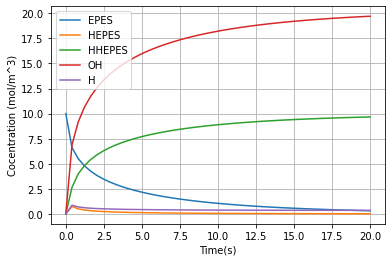

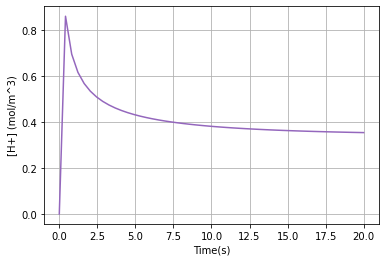

In [5]:
# COMSOL ODE model

initConc = {"H":1e-4,"OH":1.0233e-4,"EPES":10}

plotCOMSOLOdeSimulation(initConc, COMSOLParameters, tend=20)


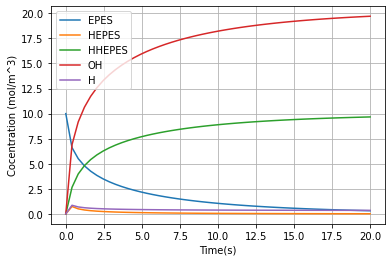

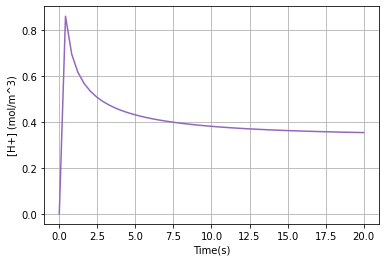

In [12]:
# COMSOL ODE model

initConc2 = {"H":1e-7,"OH":1.0233e-7,"EPES":10}

plotCOMSOLOdeSimulation(initConc2, COMSOLParameters, tend=20)


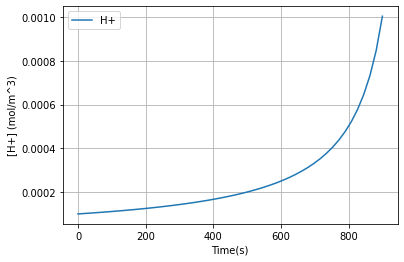

In [6]:
# buffer capacity ODE model

parameters ={"J_H":10,"pK_W":1,"H_init":1e-4}
plotSimpleOdeSpeciationSimulation(parameters,tend=900)

# References

[1] Carslaw, H. S. & Jaegar, J. C. (1959), "Conduction of heat in solids", 2nd Ed., OUP

[2] Wilson, R. E. (1979), "A note on diffusion from a continuous line source in a Time varying flow", Water Resources Research

[3] Gillespie, D. (2020), "Simulating diffusion from a cluster of point sources using Propagation integrals"

[4] Barton, G. (1989), "Elements of Green's Functions and Propagation: Potentials, Diffusion and Waves", OUP

